This is a dataset taken from http://mmcv.csie.ncku.edu.tw/~wtchu/projects/VisualWeatherPrediction/index.html
(Dataset 1). It was used in one of our initial research papers. 

The main difference we can identify in this dataset compared to the prior CCTV one is.
- Greater range of temperatures (particularly higher temperatures).
- Higher average temp
- More diversity in scenes (not just roads with surrounding landscape)

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from pathlib import Path

import torch.nn
import torchvision
import tensorflow as tf
import torchvision.transforms as transforms
import keras.optimizers
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout

In [3]:
# Specify csv file with humidity temperature and picture information
df = pd.read_csv("./data/chu/single_image/single_image_metadata.csv")
# The 5 columns here can use humidity and temperature
print(df.shape)
df.head()

(35417, 3)


,Filename,CamId,TempM
0,20130101_091628.jpg,10066,-3.0
1,20130101_114638.jpg,10066,-3.0
2,20130101_125725.jpg,10066,-2.0
3,20130101_154632.jpg,10066,-3.0
4,20130102_092726.jpg,10066,-4.0


In [4]:
#finds nth occurence of character in a string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [5]:
df.shape

(35417, 3)

In [6]:
sample1000 = df.sample(frac = (1000 / 35417))
print(sample1000.shape)
sample1000.head()

(1000, 3)


,Filename,CamId,TempM
12270,20110810_080727.jpg,3395,6.0
5313,20130126_154020.jpg,17218,-7.0
33578,20140415_081523.jpg,9291,12.0
6886,20131031_183544.jpg,17244,29.0
21833,20140430_221154.jpg,623,23.3


In [7]:
transformation = torchvision.transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

6.0


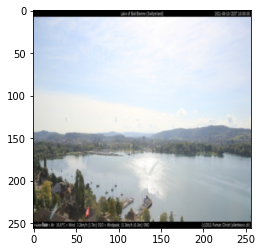

In [8]:
temperatureFeature = np.asarray(sample1000["TempM"])

imgFeature = []
imgPaths = sample1000["Filename"]
for i in range(sample1000.shape[0]):
    imgPath = sample1000.iloc[i][0]
    camID = sample1000.iloc[i][1]
    imgPath = "./data/chu/single_image/dataset/" + str(camID) + "/" + imgPath 
    img = Image.open(Path(imgPath))
    img = img.convert('RGB')
    transformedImg = transformation(img)
    transformedImg = np.asarray(transformedImg)
    transformedImg = transformedImg / 255
    imgFeature.append(transformedImg)
    
    if i % 1000 == 0:
        #print(transformedImg)
        print(temperatureFeature[i])
        plt.imshow(transformedImg)
        plt.show()
    
imgFeature = np.asarray(imgFeature)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(imgFeature, temperatureFeature, test_size=0.10)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [10]:
#here we try the exact same simple model as with the prior dataset
image_input = Input(batch_size=8, shape=(256, 256, 3))
conv1 = Conv2D(32, (3, 3), 1, padding="same", activation='relu')(image_input)
conv2 = Conv2D(64, (3, 3), 1, activation='relu')(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv2)
dropout = Dropout(0.25)(maxpool1)

flatten = Flatten()(dropout)
image_dense = Dense(128, activation='relu')(flatten)
output = Dense(1, activation='linear')(image_dense)

model = Model(inputs=image_input, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error') 

print(model.summary())

history = model.fit(X_train, Y_train, validation_split=0.2, epochs=5, batch_size=8, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(8, 256, 256, 3)]        0         
                                                                 
 conv2d (Conv2D)             (8, 256, 256, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (8, 254, 254, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2  (8, 127, 127, 64)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (8, 127, 127, 64)         0         
                                                                 
 flatten (Flatten)           (8, 1032256)              0         
                                                             

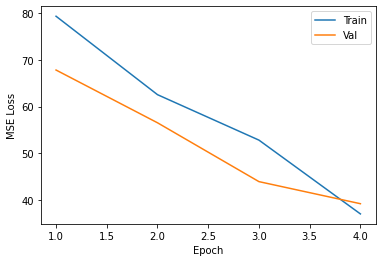

In [13]:
epochs = np.arange(1, 5)
plt.plot(epochs, history.history['loss'][1:])
plt.plot(epochs, history.history['val_loss'][1:])
plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [14]:
#compare predictions with baseline that uses training set and outputs mean temperature
Y_pred = np.transpose(np.asarray(model.predict(X_test)))[0]
Y_base = [np.mean(Y_train) for i in range(len(X_test))]

rmse = np.sqrt(((Y_test - Y_base)**2).mean(axis=0))
print("Base RMSE {}".format(rmse))
rmse = np.sqrt(((Y_test - Y_pred)**2).mean(axis=0))
print("Model RMSE {}".format(rmse))

#print some sample predictions
numPreds = len(Y_test)
print("True \t Pred")
for i in range(25):
    print("{} \t {}".format(Y_test[i], np.round(Y_pred[i], 1)))

4/4 [==============================] - 1s 316ms/step
Base RMSE 10.62597852981312
Model RMSE 7.385253898507206
True 	 Pred
15.0 	 23.100000381469727
17.0 	 7.199999809265137
10.6 	 9.399999618530273
-3.0 	 7.400000095367432
12.0 	 7.599999904632568
14.0 	 15.300000190734863
25.0 	 22.600000381469727
18.0 	 12.399999618530273
15.0 	 17.100000381469727
4.0 	 3.299999952316284
12.0 	 11.699999809265137
17.0 	 20.799999237060547
36.7 	 22.100000381469727
23.0 	 15.699999809265137
27.8 	 18.899999618530273
7.2 	 23.299999237060547
14.0 	 10.0
27.8 	 20.899999618530273
31.0 	 25.299999237060547
8.0 	 6.0
-8.0 	 0.4000000059604645
15.6 	 10.600000381469727
12.0 	 13.100000381469727
2.2 	 10.100000381469727
-1.0 	 2.700000047683716


In [15]:
estimates = [(Y_test[i], Y_pred[i]) for i in range(numPreds)]
estimates.sort(key=lambda x:x[0])
print(estimates[0:10])

[(-11.0, 7.37675), (-8.0, 0.38539892), (-6.0, 5.2766576), (-3.0, 7.352412), (-3.0, 9.253893), (-2.0, 4.771898), (-2.0, 5.8203506), (-1.0, 2.7060807), (-1.0, 11.066416), (-1.0, 6.8845124)]


Accurate
True 4.0 	 Pred 3.266937017440796


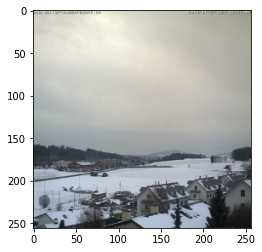

Accurate
True 12.0 	 Pred 11.742090225219727


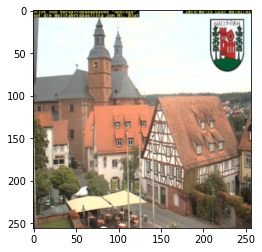

Accurate
True 8.0 	 Pred 8.705060958862305


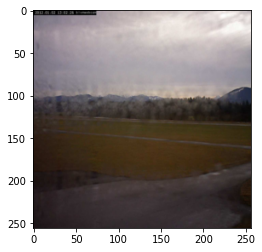

Accurate
True 12.8 	 Pred 13.69432544708252


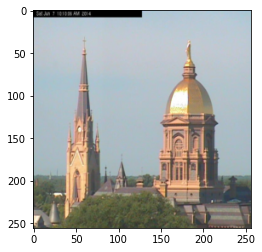

Accurate
True 24.0 	 Pred 24.14264678955078


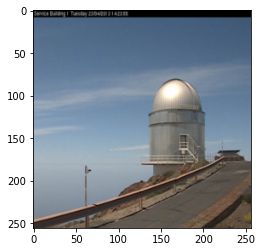

Accurate
True 17.0 	 Pred 17.80791664123535


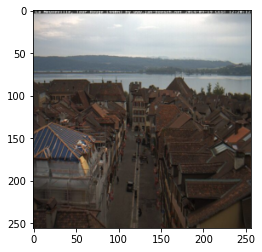

Accurate
True 6.0 	 Pred 6.613948345184326


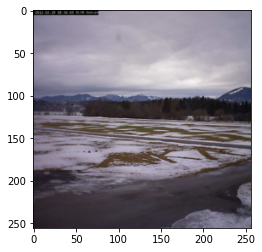

Accurate
True 23.0 	 Pred 22.508819580078125


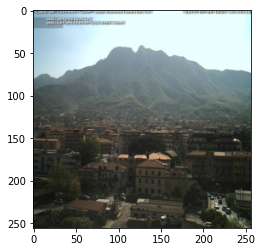

Accurate
True 1.7 	 Pred 1.8712694644927979


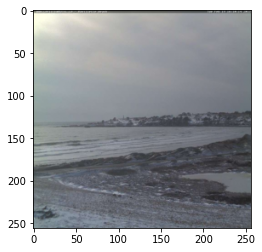

Accurate
True 13.0 	 Pred 12.522095680236816


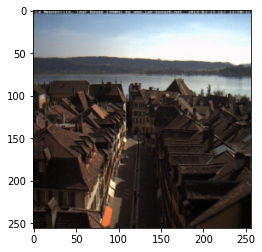

Accurate
True 11.0 	 Pred 11.151330947875977


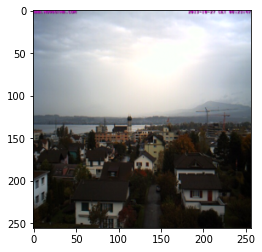

Accurate
True 5.0 	 Pred 4.369091987609863


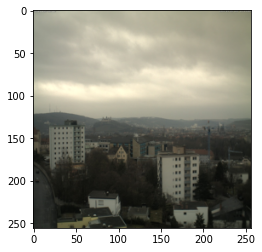

Accurate
True 8.0 	 Pred 8.49118709564209


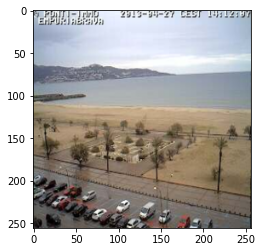

In [16]:
for i in range(numPreds):
    if abs(Y_test[i] - Y_pred[i]) < 1:
        print("Accurate")
        print("True {} \t Pred {}".format(Y_test[i], Y_pred[i]))
        plt.imshow(X_test[i])
        plt.show()
    elif abs(Y_test[i] - Y_pred[i]) > 20:
        print("Inaccurate")
        print("True {} \t Pred {}".format(Y_test[i], Y_pred[i]))
        plt.imshow(X_test[i])
        plt.show()

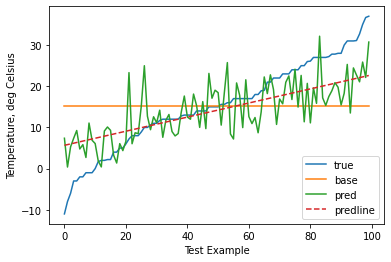

In [17]:
x = np.arange(numPreds)
y1 = [estimates[i][0] for i in range(numPreds)]
y2 = [estimates[i][1] for i in range(numPreds)]

plt.plot(x, y1)
plt.plot(x, Y_base)
plt.plot(x, y2)
yfit = np.polyfit(x, y2, 3)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), '--')
plt.xlabel("Test Example")
plt.ylabel("Temperature, deg Celsius")
plt.legend(["true", "base", "pred", "predline"])
plt.show()

The training/testing process for the models in both datasets is the same - and the model architecture is the same. But here we actually obtain some positive prediction line (red dotted). Clearly this simple model can be further improved with more complexity, more training examples, optimisation etc - but unlike on the prior dataset the loss actually decreases indicating some potential for improvement. The experiment is the same as before just on a different dataset, but this time we actually obtain some result better than the baseline.

The main theory we have is that the other CCTV dataset might simply have too low an average temperature. Some past research has suggested that predictions are worse for lower temperatures.